In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,roc_auc_score,precision_recall_curve,auc,accuracy_score
import warnings
import shap
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("/kaggle/input/finance/Financial_datasets.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print(df.shape)

(6362620, 11)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [8]:
print(df.duplicated())

0          False
1          False
2          False
3          False
4          False
           ...  
6362615    False
6362616    False
6362617    False
6362618    False
6362619    False
Length: 6362620, dtype: bool


In [9]:
#count Fraud vs non fraud transactions
fraud_counts=df['isFraud'].value_counts()
print(fraud_counts)

isFraud
0    6354407
1       8213
Name: count, dtype: int64


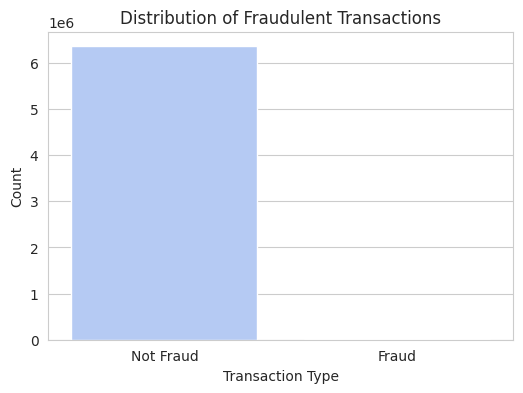

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values,palette="coolwarm")
plt.xticks([0,1],["Not Fraud", "Fraud"])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Distribution of Fraudulent Transactions")
plt.show()

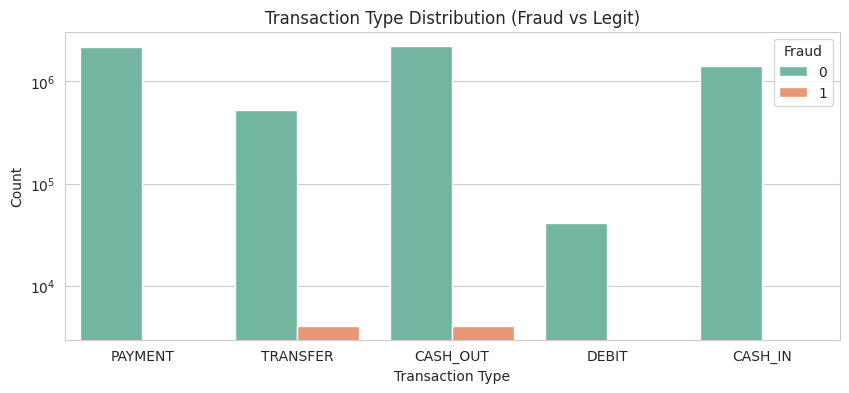

In [11]:
plt.figure(figsize=(10,4))
sns.countplot(x="type", hue="isFraud", data=df, palette="Set2")
plt.yscale('log',base=10)
plt.title("Transaction Type Distribution (Fraud vs Legit)")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title="Fraud")
plt.show()

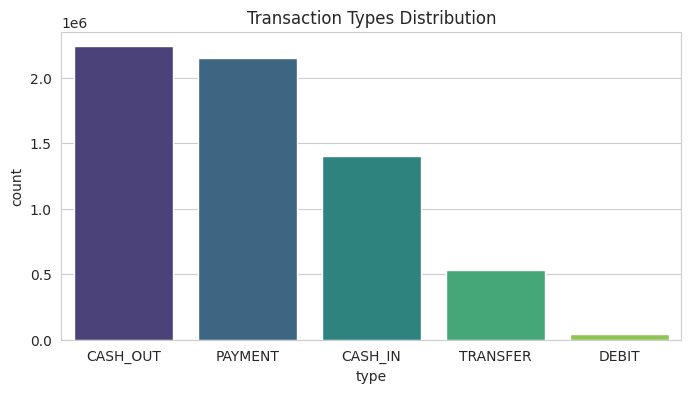

In [12]:
#count transaction types
plt.figure(figsize=(8,4))
sns.countplot(data=df,x="type",palette="viridis",order=df["type"].value_counts().index)
plt.title("Transaction Types Distribution")
plt.show()

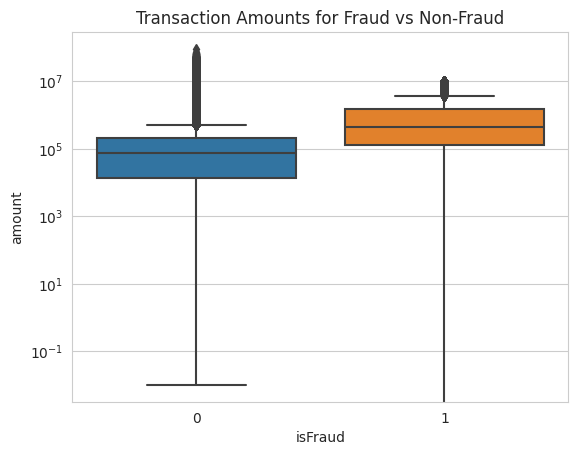

In [13]:
sns.boxplot(x="isFraud",y="amount",data=df)
plt.title("Transaction Amounts for Fraud vs Non-Fraud")
plt.yscale("log")
plt.show()

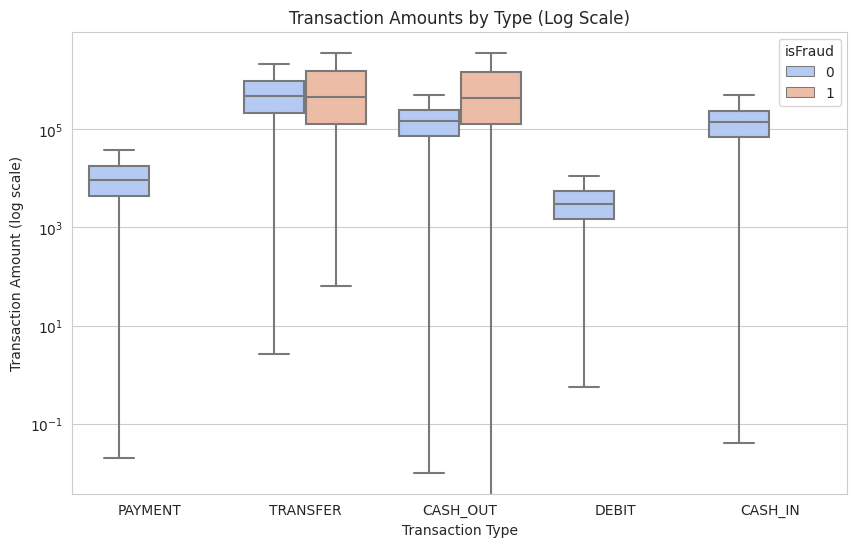

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(x="type", y="amount", hue="isFraud", data=df, showfliers=False, palette="coolwarm")
plt.yscale("log")  # scale helps visualize large amounts
plt.title("Transaction Amounts by Type (Log Scale)")
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Amount (log scale)")
plt.show()

In [15]:
df2 = df.drop(['nameOrig', 'nameDest','isFlaggedFraud','step'], axis=1)
df2.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [16]:
outliers=df2[(
    ((df2['oldbalanceOrg']==0) & (df2['amount']>0)) |
    ((df2['newbalanceOrig']==df2['oldbalanceOrg']) |
    ((df2['oldbalanceDest']==0)&(df2['newbalanceDest']>1e7))
    ))]

In [17]:
print(outliers['isFraud'].value_counts())
outliers

isFraud
0    2103044
1         57
Name: count, dtype: int64


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
29,PAYMENT,9920.52,0.00,0.00,0.00,0.00,0
30,PAYMENT,3448.92,0.00,0.00,0.00,0.00,0
31,PAYMENT,4206.84,0.00,0.00,0.00,0.00,0
32,PAYMENT,5885.56,0.00,0.00,0.00,0.00,0
33,PAYMENT,5307.88,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...
6362461,CASH_OUT,0.00,0.00,0.00,1008609.53,1008609.53,1
6362462,TRANSFER,7316255.05,17316255.05,17316255.05,0.00,0.00,1
6362463,CASH_OUT,0.00,0.00,0.00,0.00,0.00,1
6362584,TRANSFER,5674547.89,5674547.89,5674547.89,0.00,0.00,1


In [18]:
df3=df2[~(
    ((df2['oldbalanceOrg']==0) & (df2['amount']>0)) |
    ((df2['newbalanceOrig']==df2['oldbalanceOrg']) |
    ((df2['oldbalanceDest']==0)&(df2['newbalanceDest']>1e7))
    ))]

In [19]:
df3.reset_index(drop=True)
df3.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [20]:
fraud_df = df3[df3['type'].isin(['TRANSFER', 'CASH_OUT'])]
fraud_df['isFraud'].value_counts()

isFraud
0    1453055
1       8156
Name: count, dtype: int64

In [21]:
df3['balanceDiffOrig'] = df3['oldbalanceOrg'] - df3['newbalanceOrig']
df3['balanceDiffDest'] = df3['oldbalanceDest'] - df3['newbalanceDest']

In [22]:
df3

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,0.00
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,0.00
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,181.00,0.00
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,181.00,21182.00
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,339682.13,-339682.13
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,6311409.28,0.00
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,6311409.28,-6311409.27
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,850002.52,0.00


In [23]:
dummies = pd.get_dummies(df3['type'])
df3 = pd.concat([df3, dummies], axis=1)
df3.reset_index(drop=True, inplace=True)
print(df3.shape)
df3.tail()

(4259519, 14)


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4259514,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,339682.13,-339682.13,False,True,False,False,False
4259515,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,6311409.28,0.00,False,False,False,False,True
4259516,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,6311409.28,-6311409.27,False,True,False,False,False
4259517,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,850002.52,0.00,False,False,False,False,True
4259518,CASH_OUT,850002.52,850002.52,0.0,6510099.11,7360101.63,1,850002.52,-850002.52,False,True,False,False,False


In [24]:
df4 = df3.drop(['type'], axis=1)

In [25]:
df4 = df4.reset_index(drop=True)
print(df4['isFraud'].value_counts())
df4.sample(5)

isFraud
0    4251363
1       8156
Name: count, dtype: int64


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4204267,4200.72,10006.00,5805.28,0.00,0.00,0,4200.72,0.00,False,False,False,True,False
3631376,285275.75,51022.00,336297.75,0.00,0.00,0,-285275.75,0.00,True,False,False,False,False
1311946,135318.62,122886.00,258204.62,0.00,0.00,0,-135318.62,0.00,True,False,False,False,False
542281,313852.66,52123.00,365975.66,0.00,0.00,0,-313852.66,0.00,True,False,False,False,False
3045599,96327.79,1261187.29,1357515.09,3303953.56,3207625.77,0,-96327.80,96327.79,True,False,False,False,False


<Axes: >

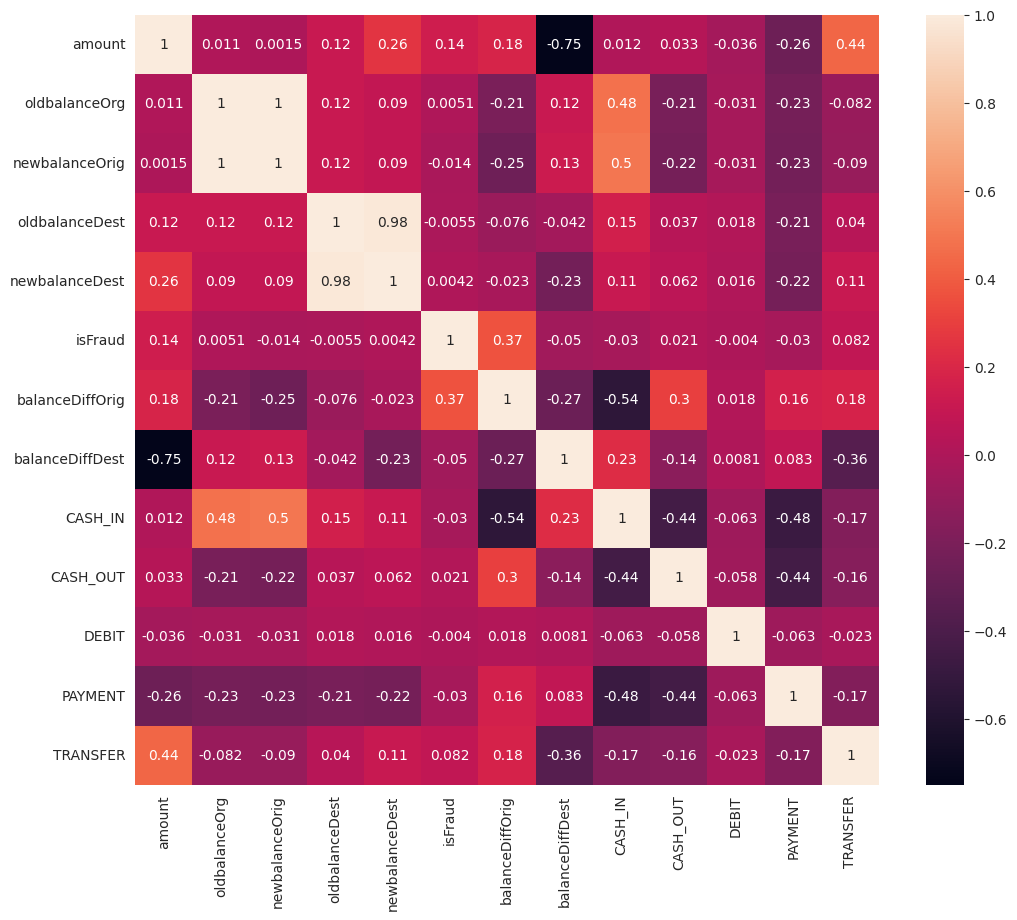

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(df4.corr(), annot=True)

In [27]:
df5 = df4.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

<Axes: >

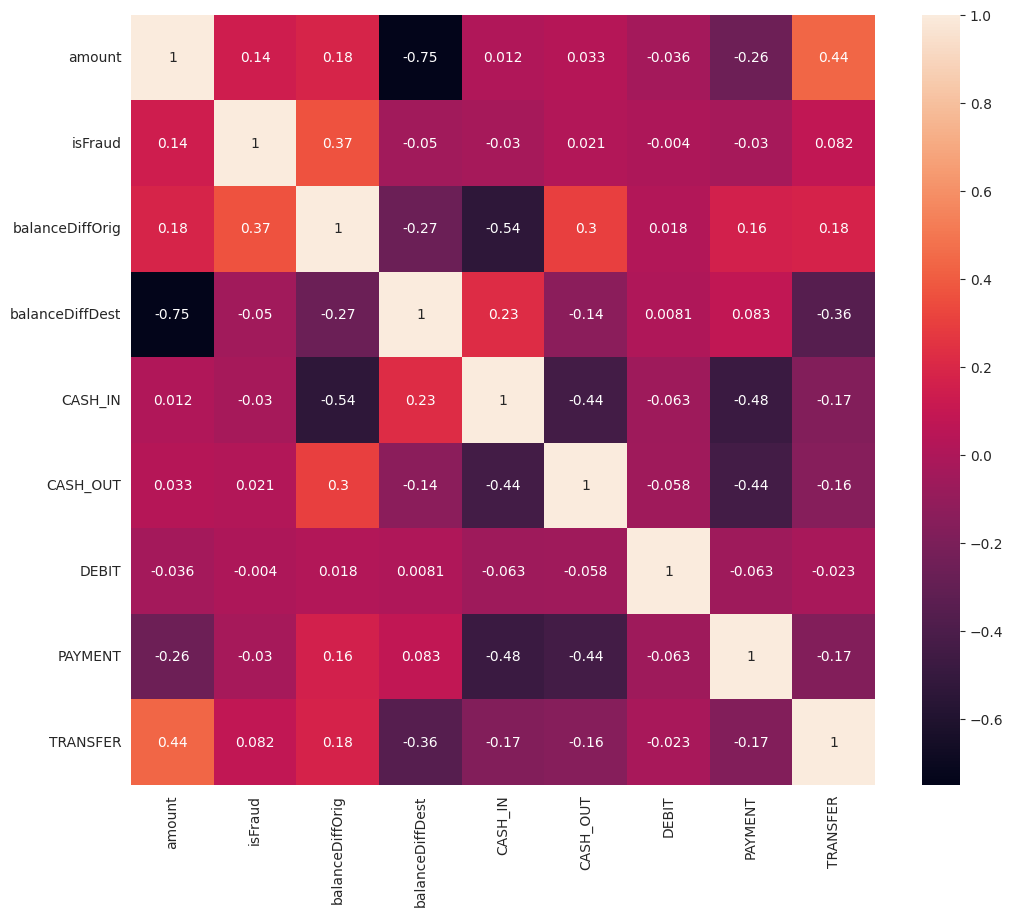

In [28]:
corr = df5.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)

In [29]:
df_majority = df5[df5.isFraud == 0]
df_minority = df5[df5.isFraud == 1]

df_majority_downsampled = resample(
    df_majority, 
    replace=False, 
    n_samples=8156, 
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority], axis=0)

In [30]:
df_balanced.reset_index(drop=True, inplace=True)
df_balanced.head()

,amount,isFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,498385.90,0,103867.00,-498385.90,False,False,False,False,True
1,113961.34,0,-113961.35,113961.34,True,False,False,False,False
2,12766.05,0,12766.05,0.00,False,False,False,True,False
3,326760.21,0,-326760.21,-181429.36,True,False,False,False,False
4,16294.33,0,10940.00,0.00,False,False,False,True,False


In [31]:
df_type = df_balanced[['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER','isFraud']]
from sklearn.preprocessing import  StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(df_balanced[['amount','balanceDiffOrig','balanceDiffDest']])
scaled_df = pd.DataFrame(scaled, columns=['amount', 'balanceDiffOrig', 'balanceDiffDest'])
df_final = pd.concat([scaled_df, df_type], axis=1)
df_final

,amount,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,-0.173381,-0.330027,-0.063831,False,False,False,False,True,0
1,-0.382611,-0.447236,0.365680,True,False,False,False,False,0
2,-0.437689,-0.379047,0.285745,False,False,False,True,False,0
3,-0.266791,-0.561739,0.158488,True,False,False,False,False,0
4,-0.435768,-0.380030,0.285745,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...
16307,-0.259758,-0.203140,0.047487,False,True,False,False,False,1
16308,2.990470,3.010122,0.285745,False,False,False,False,True,1
16309,2.990470,3.010122,-4.141181,False,True,False,False,False,1
16310,0.017994,0.071453,0.285745,False,False,False,False,True,1


In [32]:
X = df_final.drop('isFraud', axis=1)
y = df_final['isFraud']
X.shape, y.shape

((16312, 8), (16312,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
 !pip uninstall scikit-learn -y
!pip uninstall imbalanced-learn -y
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.13.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.4 MB/s eta 0:00:00:00:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.2 MB/s eta 0:00:0000:01


In [35]:
pip install scikit-learn==1.3.2 imbalanced-learn==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.2 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
Note: you may need to restart the kernel to use updated packages.


In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

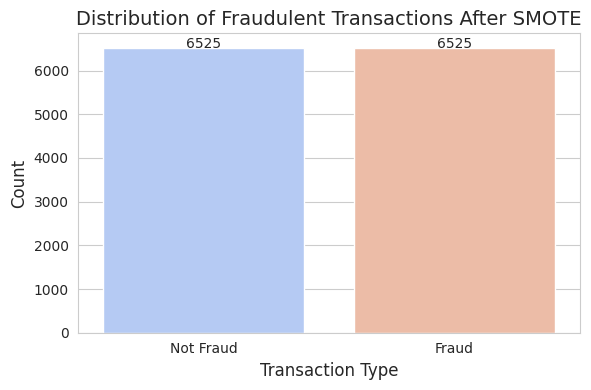

In [73]:
fraud_counts = pd.Series(y_train).value_counts().sort_index()
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")
plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Fraudulent Transactions After SMOTE", fontsize=14)
for index, value in enumerate(fraud_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [37]:
scale_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_weight

1.0

In [38]:
def model_performance(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate metrics for class 1 (fraud)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)

    print(f"Recall (Fraud):     {round(recall*100, 2)}%")
    print(f"Precision (Fraud):  {round(precision*100, 2)}%%")
    print(f"F1 Score:           {round(f1*100, 2)}%")
    print(f"AUC-ROC Score:      {round(auc_roc*100, 2)}%")

In [39]:
def classification_report_detailed(model):
    y_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Not Fraud", "Fraud"], 
                yticklabels=["Not Fraud", "Fraud"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

In [40]:

def precision_recall_auc_curve(model):  
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)


    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  
    axes[0].plot(recall, precision, color='b')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    axes[1].plot(thresholds, precisions[:-1], label='Precision')
    axes[1].plot(thresholds, recalls[:-1], label='Recall')
    axes[1].set_xlabel('Threshold')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title('Precision vs Recall vs Threshold')

  
    plt.tight_layout()
    plt.show()

Model score: 0.9653692920625192
Training accuracy: 0.9709
Test accuracy: 0.9654


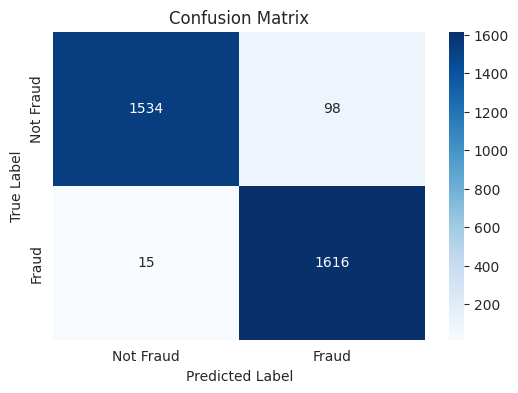


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1632
           1       0.94      0.99      0.97      1631

    accuracy                           0.97      3263
   macro avg       0.97      0.97      0.97      3263
weighted avg       0.97      0.97      0.97      3263



In [41]:
Xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
)

Xgb.fit(X_train, y_train)
print('Model score:',Xgb.score(X_test, y_test))
cm = confusion_matrix(y_test, Xgb.predict(X_test))
classification_report_detailed(Xgb)

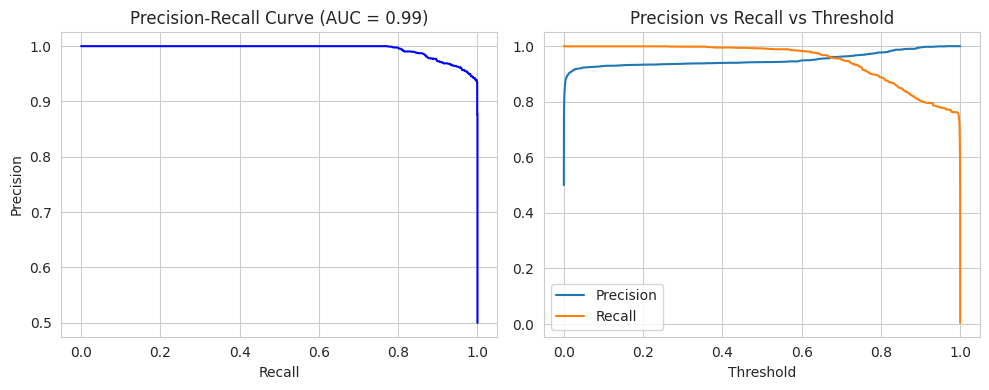

In [42]:
precision_recall_auc_curve(Xgb)

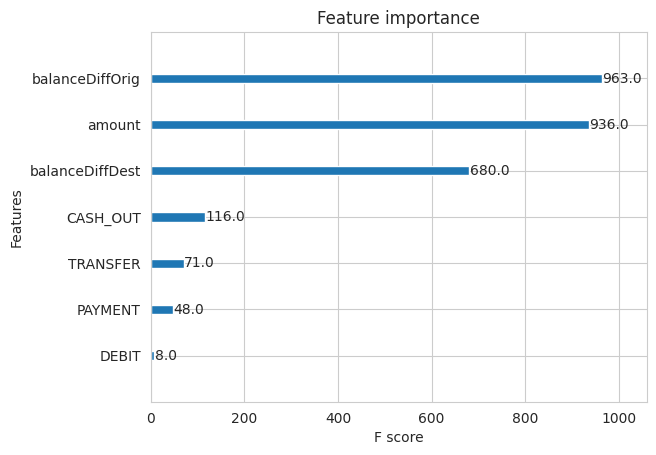

In [43]:
xgb.plot_importance(Xgb,max_num_features=10)
plt.show()

Model score: 0.9635304934109715
Training accuracy: 0.9661
Test accuracy: 0.9635


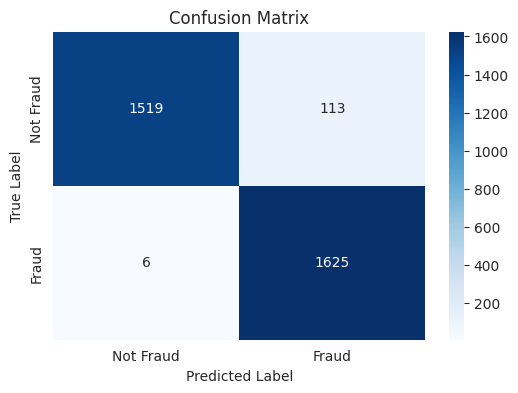


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1632
           1       0.93      1.00      0.96      1631

    accuracy                           0.96      3263
   macro avg       0.97      0.96      0.96      3263
weighted avg       0.97      0.96      0.96      3263



In [44]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
print('Model score:',rf_model.score(X_test, y_test))
cm = confusion_matrix(y_test, rf_model.predict(X_test))
classification_report_detailed(rf_model)

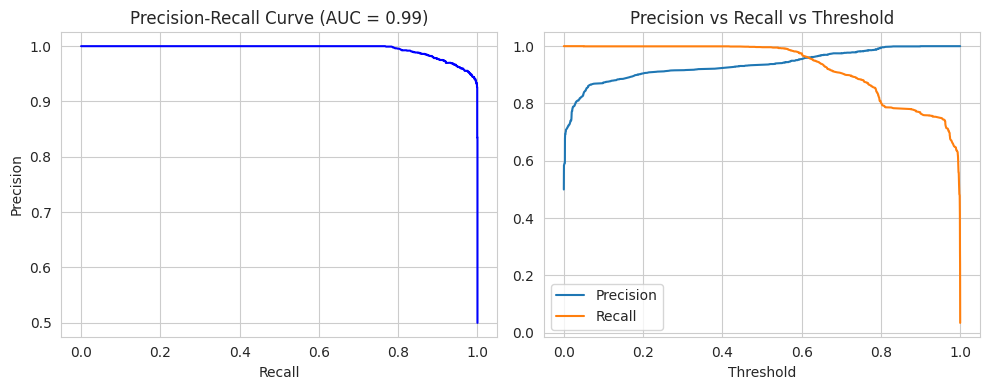

In [45]:
precision_recall_auc_curve(rf_model)

Model score: 0.9515783021759118
Training accuracy: 0.9515
Test accuracy: 0.9516


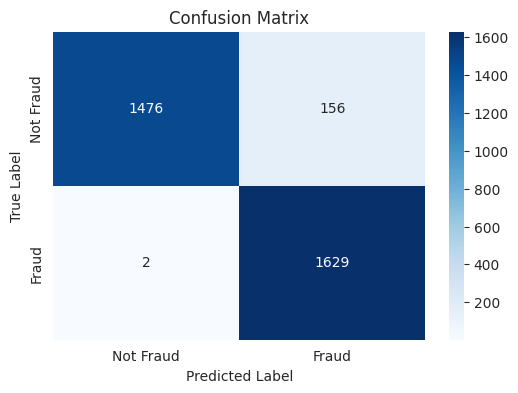


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1632
           1       0.91      1.00      0.95      1631

    accuracy                           0.95      3263
   macro avg       0.96      0.95      0.95      3263
weighted avg       0.96      0.95      0.95      3263



In [46]:
dt_model = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 10}) 
dt_model.fit(X_train, y_train)
print('Model score:',dt_model.score(X_test, y_test))
cm = confusion_matrix(y_test, dt_model.predict(X_test))
classification_report_detailed(dt_model)

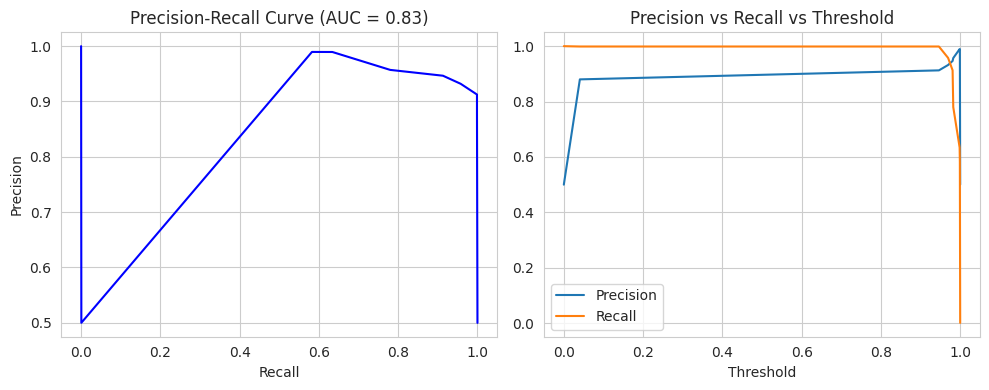

In [47]:
precision_recall_auc_curve(dt_model)

Model score: 0.9580842911877394
Training accuracy: 0.9581
Test accuracy: 0.9559


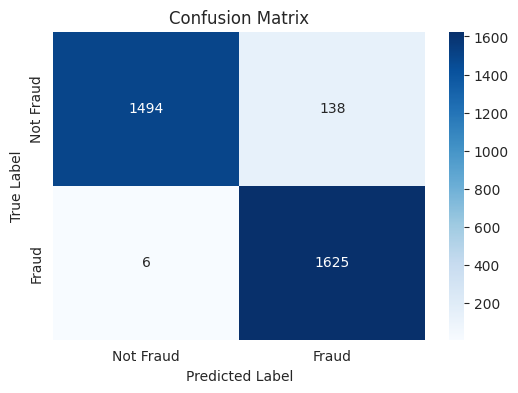


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1632
           1       0.92      1.00      0.96      1631

    accuracy                           0.96      3263
   macro avg       0.96      0.96      0.96      3263
weighted avg       0.96      0.96      0.96      3263



In [48]:
lr_model = LogisticRegression(C=10, solver = 'liblinear', class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)
print('Model score:',lr_model.score(X_train, y_train))
cm = confusion_matrix(y_test, lr_model.predict(X_test))
classification_report_detailed(lr_model)

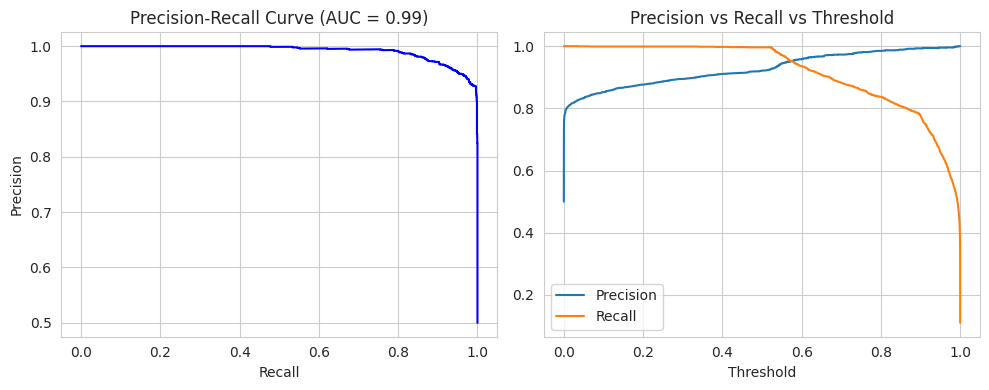

In [49]:
precision_recall_auc_curve(lr_model)

Model score: 0.9699616858237547
Training accuracy: 0.9700
Test accuracy: 0.9632


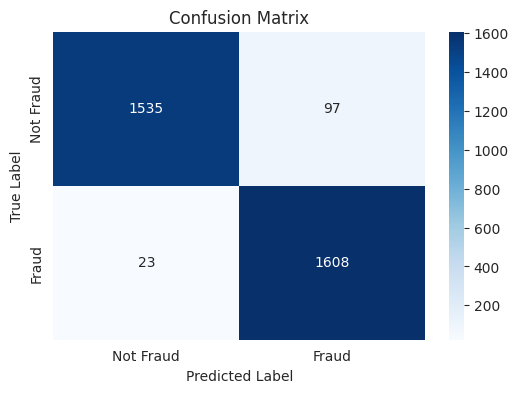


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1632
           1       0.94      0.99      0.96      1631

    accuracy                           0.96      3263
   macro avg       0.96      0.96      0.96      3263
weighted avg       0.96      0.96      0.96      3263



In [50]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

print("Model score:", knn_model.score(X_train, y_train))
classification_report_detailed(knn_model)


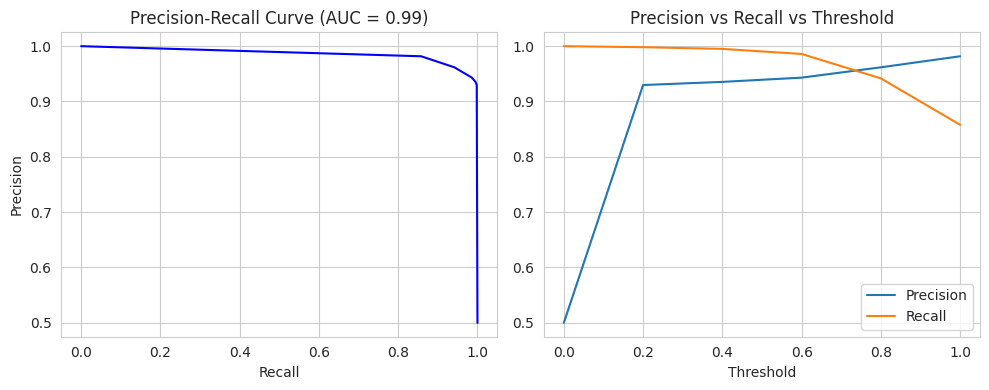

In [51]:
precision_recall_auc_curve(knn_model)

Model score: 0.9087356321839081
Training accuracy: 0.9087
Test accuracy: 0.9130


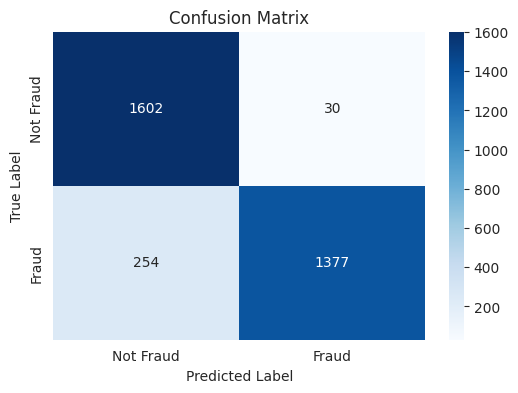


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1632
           1       0.98      0.84      0.91      1631

    accuracy                           0.91      3263
   macro avg       0.92      0.91      0.91      3263
weighted avg       0.92      0.91      0.91      3263



In [52]:
perceptron_model = Perceptron(random_state=42)
perceptron_model.fit(X_train, y_train)

print("Model score:", perceptron_model.score(X_train, y_train))
classification_report_detailed(perceptron_model)


Model score: 0.9558620689655173
Training accuracy: 0.9559
Test accuracy: 0.9543


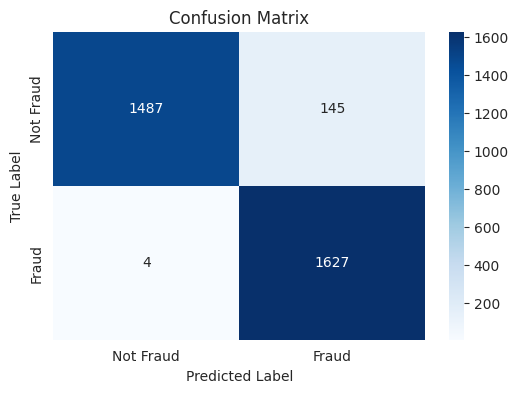


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1632
           1       0.92      1.00      0.96      1631

    accuracy                           0.95      3263
   macro avg       0.96      0.95      0.95      3263
weighted avg       0.96      0.95      0.95      3263



In [53]:
linear_svc_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=5000)
linear_svc_model.fit(X_train, y_train)

print("Model score:", linear_svc_model.score(X_train, y_train))
classification_report_detailed(linear_svc_model)


[LightGBM] [Info] Number of positive: 6525, number of negative: 6525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 13050, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model score: 0.973103448275862
Training accuracy: 0.9731
Test accuracy: 0.9648


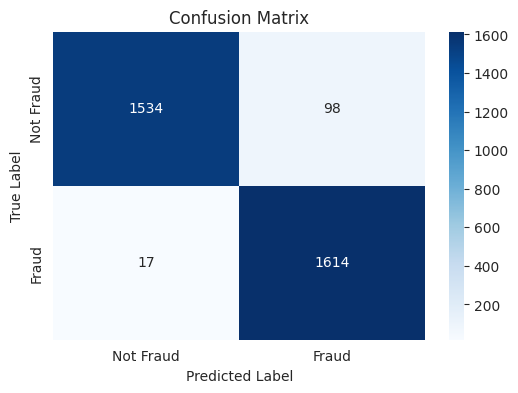


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1632
           1       0.94      0.99      0.97      1631

    accuracy                           0.96      3263
   macro avg       0.97      0.96      0.96      3263
weighted avg       0.97      0.96      0.96      3263



In [54]:
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

print("Model score:", lgbm_model.score(X_train, y_train))
classification_report_detailed(lgbm_model)


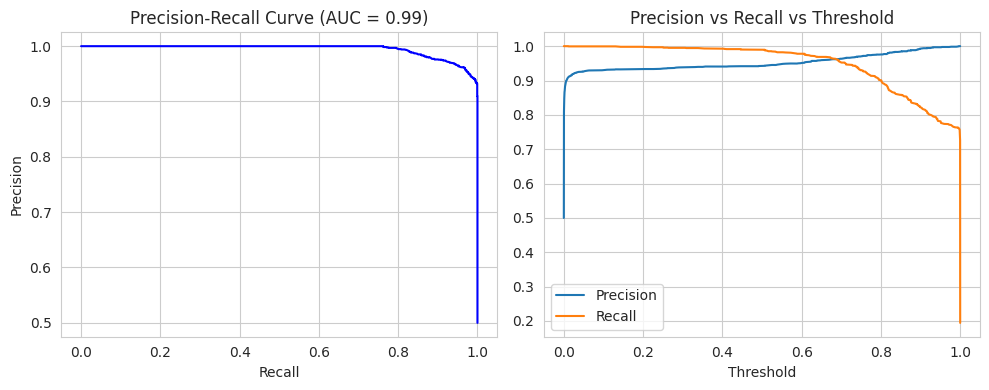

In [55]:
precision_recall_auc_curve(lgbm_model)

Model score: 0.959463601532567
Training accuracy: 0.9595
Test accuracy: 0.9562


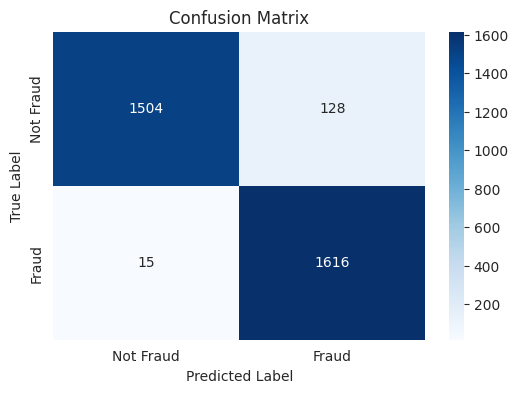


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1632
           1       0.93      0.99      0.96      1631

    accuracy                           0.96      3263
   macro avg       0.96      0.96      0.96      3263
weighted avg       0.96      0.96      0.96      3263



In [56]:
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model.fit(X_train, y_train)

print("Model score:", adaboost_model.score(X_train, y_train))
classification_report_detailed(adaboost_model)


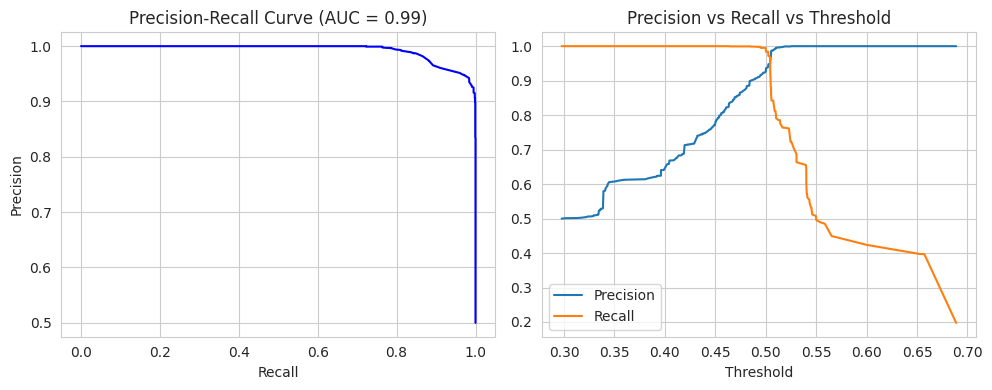

In [57]:
precision_recall_auc_curve(adaboost_model)

In [58]:
models_list = [
    ("XGBoost", Xgb),
    ("RandomForestClassifier",rf_model ),
    ("DecisionTreeClassifier",dt_model ),
    ("KNN", knn_model),
    ("Perceptron", perceptron_model),
    ("LinearSVC", linear_svc_model),
    ("LGBMClassifier", lgbm_model),
    ("AdaBoostClassifier", adaboost_model),
    ("LogisticRegression", lr_model)
]

performance_data = []

for name, model in models_list:
    y_pred = model.predict(X_test)
    
    performance_data.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0)
    })

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.sort_values(by="F1 Score", ascending=False)
performance_df.reset_index(drop=True, inplace=True)

performance_df


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.965369,0.942824,0.990803,0.966218
1,LGBMClassifier,0.964756,0.942757,0.989577,0.965600
2,RandomForestClassifier,0.963530,0.934983,0.996321,0.964678
3,KNN,0.963224,0.943109,0.985898,0.964029
4,AdaBoostClassifier,0.956175,0.926606,0.990803,0.957630
5,LogisticRegression,0.955869,0.921724,0.996321,0.957572
6,LinearSVC,0.954337,0.918172,0.997548,0.956215
7,DecisionTreeClassifier,0.951578,0.912605,0.998774,0.953747
8,Perceptron,0.912964,0.978678,0.844267,0.906517


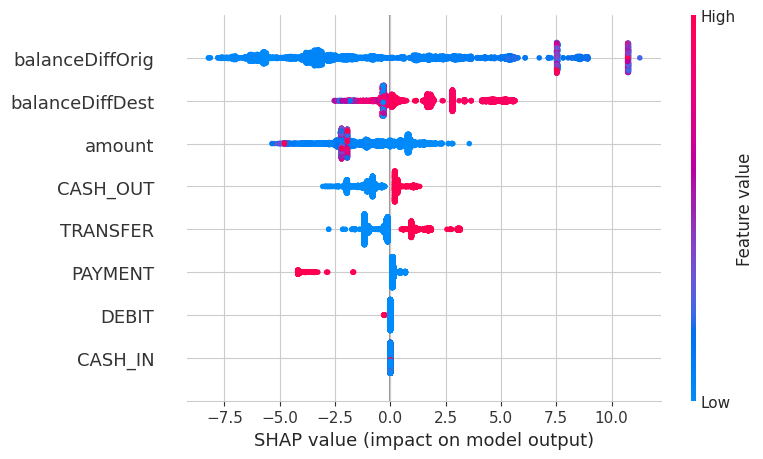

In [59]:
X_sample = X_test.copy()
explainer = shap.TreeExplainer(Xgb)
shap_values = explainer.shap_values(X_sample)
shap.initjs()
shap.summary_plot(shap_values, X_sample)


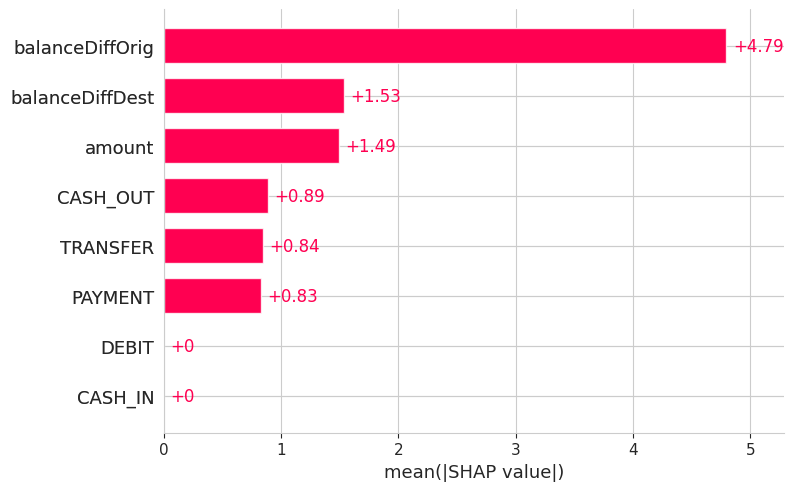

In [60]:
explainer = shap.TreeExplainer(Xgb)
X_sample = X_test.copy()
shap_values = explainer(X_sample)
shap.plots.bar(shap_values)

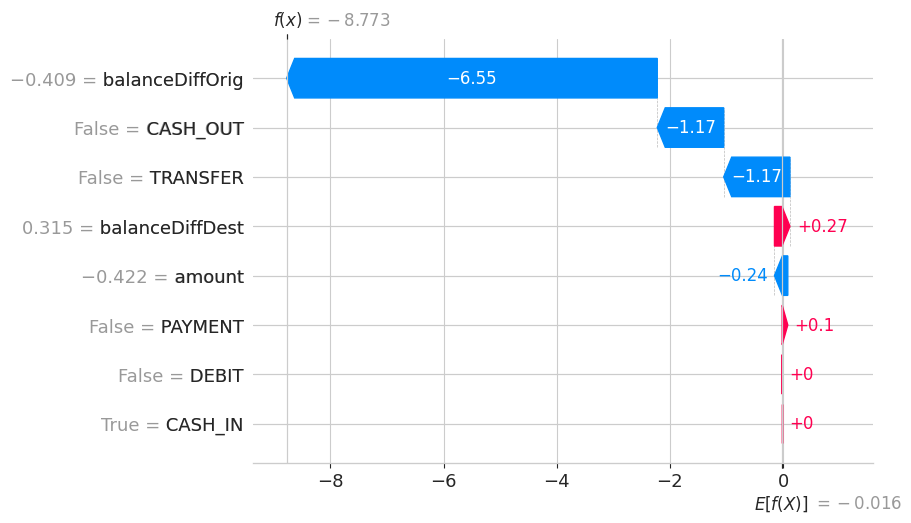

In [61]:
explainer = shap.TreeExplainer(Xgb)
X_sample = X_test.copy()
shap_values = explainer(X_sample)
shap.plots.waterfall(shap_values[0])

In [62]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
model = Xgb
X = X_train.copy()
y = y_train.copy()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-validation F1 scores: [0.97085202 0.96716418 0.96646796 0.96608274 0.96276992]
Mean F1: 0.9667 (+/- 0.0052)


In [63]:
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(Xgb, file)

In [65]:
df_final.describe()

,amount,balanceDiffOrig,balanceDiffDest,isFraud
count,16312.000000,16312.000000,16312.000000,16312.000000
mean,0.000000,0.000000,0.000000,0.500000
std,1.000031,1.000031,1.000031,0.500015
min,-0.444633,-0.867478,-28.749814,0.000000
25%,-0.422890,-0.383901,0.143623,0.000000
50%,-0.349681,-0.360295,0.285745,0.500000
75%,-0.155676,-0.147151,0.285745,1.000000
max,4.998057,4.994876,1.096547,1.000000


In [70]:
df_final.describe(include='all')

,amount,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
count,16312.000000,16312.000000,16312.000000,16312,16312,16312,16312,16312,16312.000000
unique,NaN,NaN,NaN,2,2,2,2,2,NaN
top,NaN,NaN,NaN,False,False,False,False,False,NaN
freq,NaN,NaN,NaN,13694,9842,16252,13705,11755,NaN
mean,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.500000
std,1.000031,1.000031,1.000031,NaN,NaN,NaN,NaN,NaN,0.500015
min,-0.444633,-0.867478,-28.749814,NaN,NaN,NaN,NaN,NaN,0.000000
25%,-0.422890,-0.383901,0.143623,NaN,NaN,NaN,NaN,NaN,0.000000
50%,-0.349681,-0.360295,0.285745,NaN,NaN,NaN,NaN,NaN,0.500000
75%,-0.155676,-0.147151,0.285745,NaN,NaN,NaN,NaN,NaN,1.000000
